# 1. Carregamento e Preparação dos Dados
* Leitura do arquivo CSV e conversão da coluna de datas para o formato datetime.
* Ordenação dos dados pela data para manter a sequência temporal.
* Visualização inicial para entender a variação histórica dos preços.

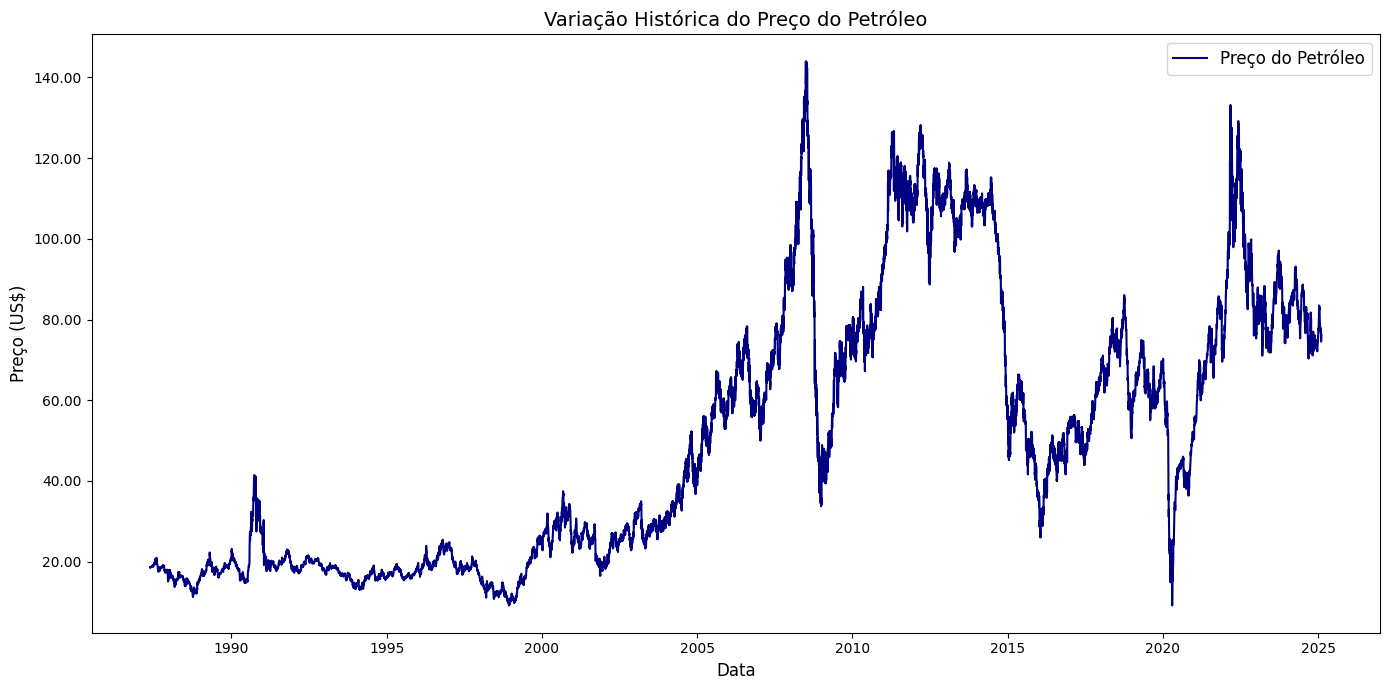

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
import datetime

# 1. Carregamento e Preparação dos Dados
df = pd.read_csv("base_preco_petroleo.csv")

# Conversão da coluna 'Data' para datetime
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Ordenação dos dados pela data
df.sort_values('Data', inplace=True)
df.reset_index(drop=True, inplace=True)

# Conversão dos preços: remove espaços e substitui vírgula por ponto, convertendo para float
df['Preco do Petroleo'] = df['Preco do Petroleo'].astype(str).str.strip().str.replace(',', '.').astype(float)

# Visualização inicial melhorada do gráfico
plt.figure(figsize=(14, 7))
plt.plot(df['Data'], df['Preco do Petroleo'], label="Preço do Petróleo", color='navy')

# Formatação do eixo Y: Função para formatação com separador de milhar ou com poucas casas decimais
def y_formatter(x, pos):
    return f'{x:,.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço (US$)", fontsize=12)
plt.title("Variação Histórica do Preço do Petróleo", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 2. Seleção do Período e Normalização
* Para evitar problemas de overfitting e trabalhar com dados mais recentes,
defini uma data de corte (por exemplo, a partir de 06/01/2020).
* Normalização dos preços utilizando o `MinMaxScaler`, transformando os valores para a escala [0,1].

In [16]:
# 2. Seleção do Período e Normalização dos Dados
data_cut = pd.to_datetime("2020-06-01")
df_filtered = df[df['Data'] >= data_cut].copy()
df_filtered.reset_index(drop=True, inplace=True)

prices = df_filtered['Preco do Petroleo'].values.reshape(-1, 1)
scaler = MinMaxScaler()
prices_normalized = scaler.fit_transform(prices)

# 3. Criação das Sequências para o Modelo LSTM
* Definição de uma função create_sequences que cria sequências de entrada (X) e o próximo valor como saída (y) com base em um tamanho de sequência definido (ex.: 10).
* Separação dos dados normalizados em conjuntos de treinamento (80%) e teste (20%).


In [17]:
# Criando sequências
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Definindo o comprimento da sequência
sequence_length = 10

# Criação das sequências
X, y = create_sequences(prices_normalized, sequence_length)

# Divisão em conjuntos de treino e teste (80% treino, 20% teste)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. Construção e Treinamento do Modelo LSTM
* Criação de um modelo sequencial com uma camada LSTM contendo 350 unidades e uma camada densa final com 1 neurônio.
* Compilação do modelo com o otimizador Adam e a função de perda MSE.
Treinamento do modelo por 100 épocas com tamanho de batch igual a 64.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Construção do modelo LSTM
model = Sequential()
model.add(LSTM(350, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mse')

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1)
# Salvando o modelo treinado
model.save("meu_modelo.h5")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0964 - val_loss: 0.0073
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0069 - val_loss: 0.0022
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0031 - val_loss: 7.6396e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0018 - val_loss: 6.1715e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0014 - val_loss: 6.3610e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0014 - val_loss: 6.4660e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0014 - val_loss: 7.6416e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0015 - val_loss: 6.0577e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0012 - val_loss: 6.6844e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0012 - val_loss: 6.0338e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0012 - val_loss: 6.4301e-04
Epoch 12/100
15/15 ━━━━━━━

# 5. Avaliação do Modelo
* Previsão dos valores de teste utilizando o modelo treinado.
* Cálculo das métricas de desempenho: R², MSE, MAE, MAPE e RMSE.

In [19]:
# Previsões no conjunto de teste
y_pred_normalized = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_normalized)
y_test_actual = scaler.inverse_transform(y_test)

# Cálculo das métricas
r2 = r2_score(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
rmse = math.sqrt(mse)

# Impressão das métricas
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"RMSE: {rmse:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
R² Score: 0.9123
MSE: 2.6815
MAE: 1.2990
MAPE: 1.6364%
RMSE: 1.6375


# 6. Previsão Futura e Visualização
* Definição de funções para prever os próximos pontos da série (função predict_future) e gerar as datas correspondentes.
* Visualização do histórico filtrado juntamente com as previsões para os próximos 15 dias.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


<ipython-input-20-60e1cd3e10f0>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction_list = [float(item) for item in data[-sequence_length:]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


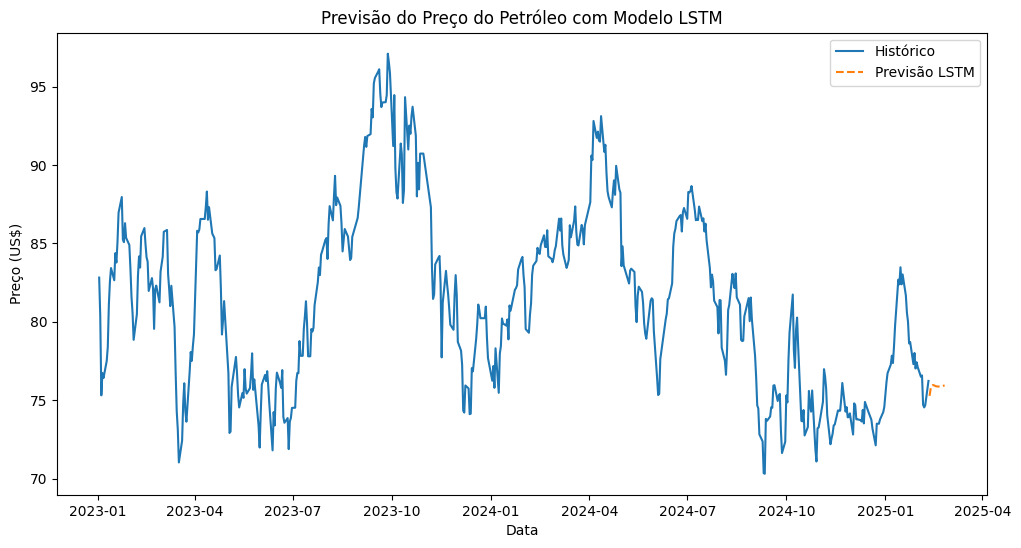

In [20]:
# Função para realizar previsões futuras a partir dos últimos dados conhecidos
def predict_future(model, data, num_prediction, sequence_length, scaler):
    # Converte os últimos sequence_length pontos para float para garantir homogeneidade
    prediction_list = [float(item) for item in data[-sequence_length:]]

    for _ in range(num_prediction):
        # Converte a lista para array NumPy e reshape para (1, sequence_length, 1)
        x = np.array(prediction_list[-sequence_length:], dtype=float).reshape((1, sequence_length, 1))
        out = model.predict(x)[0][0]
        prediction_list.append(out)
    # Seleciona apenas os valores previstos (excluindo os dados de entrada)
    prediction_list = prediction_list[sequence_length:]
    # Desnormaliza as previsões
    prediction_list = scaler.inverse_transform(np.array(prediction_list).reshape(-1, 1))
    return prediction_list

# Função para gerar datas futuras com base na última data do DataFrame
def predict_dates(last_date, num_prediction):
    return pd.date_range(start=last_date + datetime.timedelta(days=1), periods=num_prediction).tolist()

# Definindo o número de dias a serem previstos
num_prediction = 15
forecast = predict_future(model, prices_normalized, num_prediction, sequence_length, scaler)
forecast_dates = predict_dates(df_filtered['Data'].iloc[-1], num_prediction)

# Preparação para plotagem: dados históricos a partir de uma data de corte para melhor visualização
data_cut_plot = pd.to_datetime("2023-01-01")
df_plot = df_filtered[df_filtered['Data'] >= data_cut_plot].copy()

# Plotando os dados históricos e a previsão futura
plt.figure(figsize=(12,6))
plt.plot(df_plot['Data'], df_plot['Preco do Petroleo'], label="Histórico")
plt.plot(forecast_dates, forecast, label="Previsão LSTM", linestyle="--")
plt.xlabel("Data")
plt.ylabel("Preço (US$)")
plt.title("Previsão do Preço do Petróleo com Modelo LSTM")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

<ipython-input-20-60e1cd3e10f0>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction_list = [float(item) for item in data[-sequence_length:]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


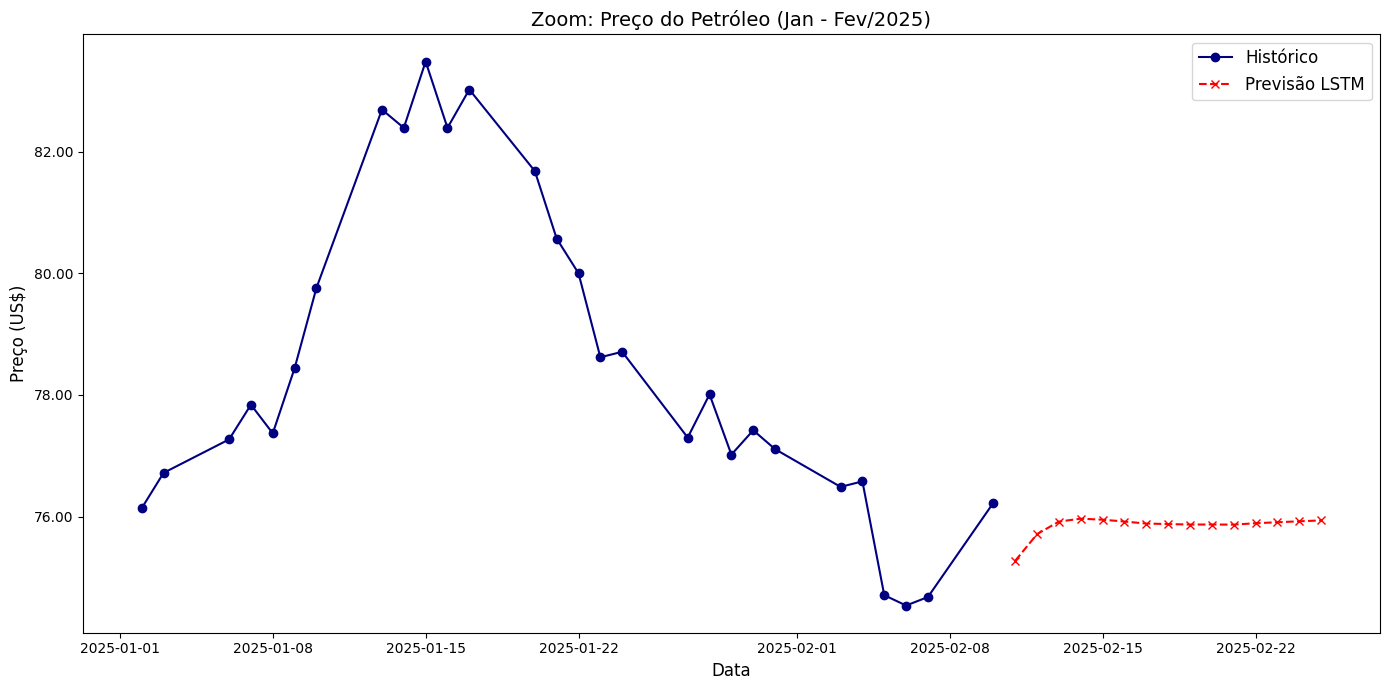

Tabela de Dados (Histórico + Previsão) para o Período de 01/01/2025 a 25/02/2025:
      Data  Preco do Petroleo      Tipo
2025-01-02          76.140000 Histórico
2025-01-03          76.720000 Histórico
2025-01-06          77.270000 Histórico
2025-01-07          77.840000 Histórico
2025-01-08          77.370000 Histórico
2025-01-09          78.440000 Histórico
2025-01-10          79.760000 Histórico
2025-01-13          82.690000 Histórico
2025-01-14          82.390000 Histórico
2025-01-15          83.480000 Histórico
2025-01-16          82.390000 Histórico
2025-01-17          83.020000 Histórico
2025-01-20          81.680000 Histórico
2025-01-21          80.570000 Histórico
2025-01-22          80.000000 Histórico
2025-01-23          78.620000 Histórico
2025-01-24          78.710000 Histórico
2025-01-27          77.300000 Histórico
2025-01-28          78.010000 Histórico
2025-01-29          77.020000 Histórico
2025-01-30          77.420000 Histórico
2025-01-31          77.110000 Históric

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime

# Definindo o número de dias a serem previstos (ex.: 15 dias)
num_prediction = 15
forecast = predict_future(model, prices_normalized, num_prediction, sequence_length, scaler)
forecast_dates = predict_dates(df_filtered['Data'].iloc[-1], num_prediction)

# Converter as previsões para um DataFrame
df_forecast = pd.DataFrame({
    'Data': forecast_dates,
    'Preco do Petroleo': forecast.flatten(),
    'Tipo': 'Previsão'
})

# Selecionar o período de interesse: de 01/01/2025 até 25/02/2025 (por exemplo)
start_zoom = pd.to_datetime("2025-01-01")
end_zoom = pd.to_datetime("2025-02-25")

# Dados históricos (já existentes) dentro do período de zoom
df_historico_zoom = df_filtered[(df_filtered['Data'] >= start_zoom) & (df_filtered['Data'] <= end_zoom)].copy()
df_historico_zoom['Tipo'] = 'Histórico'

# Combinar os dados históricos e as previsões que caem no período de zoom
# Algumas previsões podem estar fora do período; vamos filtrar as previsões também.
df_forecast_zoom = df_forecast[(df_forecast['Data'] >= start_zoom) & (df_forecast['Data'] <= end_zoom)].copy()

# Concatenar os DataFrames para criar uma tabela completa
df_zoom = pd.concat([df_historico_zoom, df_forecast_zoom]).sort_values('Data').reset_index(drop=True)

# Gráfico: zoom no período de janeiro e fevereiro de 2025
plt.figure(figsize=(14, 7))

# Plotar os dados históricos
plt.plot(df_historico_zoom['Data'], df_historico_zoom['Preco do Petroleo'], label="Histórico", marker='o', color='navy')

# Plotar as previsões
plt.plot(df_forecast_zoom['Data'], df_forecast_zoom['Preco do Petroleo'], label="Previsão LSTM", marker='x', linestyle="--", color='red')

# Formatação do eixo Y para facilitar a leitura
def y_formatter(x, pos):
    return f'{x:,.2f}'
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))

plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço (US$)", fontsize=12)
plt.title("Zoom: Preço do Petróleo (Jan - Fev/2025)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Exibindo a tabela dos dados (históricos + previsão) no período selecionado
print("Tabela de Dados (Histórico + Previsão) para o Período de 01/01/2025 a 25/02/2025:")
print(df_zoom[['Data', 'Preco do Petroleo', 'Tipo']].to_string(index=False))
